In [4]:
import ccxt
import pandas as pd
import datetime
import time

# Initialize Binance
binance = ccxt.binance()
symbol = 'ETH/USDT'
timeframe = '2h'
limit = 1500  # Max candles per request
since = binance.parse8601((datetime.datetime.utcnow() - datetime.timedelta(days=365*3)).isoformat())

all_ohlcv = []

while True:
    print(f"Fetching from: {binance.iso8601(since)}")
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)

    if not ohlcv:
        break

    all_ohlcv += ohlcv
    since = ohlcv[-1][0] + 1  # move to the next candle

    # Respect Binance rate limits
    time.sleep(binance.rateLimit / 1000)

    # Break early if already covered the last 3 years
    if len(all_ohlcv) >= (3 * 365 * 24 // 2):  # ~13k candles for 3 years of 2h
        break

# Convert to DataFrame
df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Save to CSV (optional)
df.to_csv('eth_usdt_2h_3y.csv')

# Show result
print(f"Fetched {len(df)} candles")
print(df.head())


Fetching from: 2022-07-21T13:04:35.917Z
Fetching from: 2022-10-12T20:00:00.001Z
Fetching from: 2023-01-04T04:00:00.001Z
Fetching from: 2023-03-28T12:00:00.001Z
Fetching from: 2023-06-19T20:00:00.001Z
Fetching from: 2023-09-11T04:00:00.001Z
Fetching from: 2023-12-03T12:00:00.001Z
Fetching from: 2024-02-24T20:00:00.001Z
Fetching from: 2024-05-18T04:00:00.001Z
Fetching from: 2024-08-09T12:00:00.001Z
Fetching from: 2024-10-31T20:00:00.001Z
Fetching from: 2025-01-23T04:00:00.001Z
Fetching from: 2025-04-16T12:00:00.001Z
Fetching from: 2025-07-08T20:00:00.001Z
Fetched 13140 candles
                        open     high      low    close       volume
timestamp                                                           
2022-07-21 14:00:00  1504.93  1514.77  1481.11  1511.01   91307.0447
2022-07-21 16:00:00  1511.01  1570.00  1508.99  1536.23  175519.6253
2022-07-21 18:00:00  1536.23  1580.00  1533.57  1578.85   83686.1204
2022-07-21 20:00:00  1578.84  1605.98  1574.72  1589.32   97956.0124
2022

In [5]:
df

,open,high,low,close,volume
timestamp,,,,,
2022-07-21 14:00:00,1504.93,1514.77,1481.11,1511.01,91307.0447
2022-07-21 16:00:00,1511.01,1570.00,1508.99,1536.23,175519.6253
2022-07-21 18:00:00,1536.23,1580.00,1533.57,1578.85,83686.1204
2022-07-21 20:00:00,1578.84,1605.98,1574.72,1589.32,97956.0124
2022-07-21 22:00:00,1589.32,1590.77,1565.09,1575.45,71090.1213
...,...,...,...,...,...
2025-07-20 04:00:00,3658.01,3666.22,3633.18,3647.21,46251.6787
2025-07-20 06:00:00,3647.21,3689.97,3639.22,3668.49,37391.3221
2025-07-20 08:00:00,3668.50,3727.34,3668.50,3707.12,108869.2864


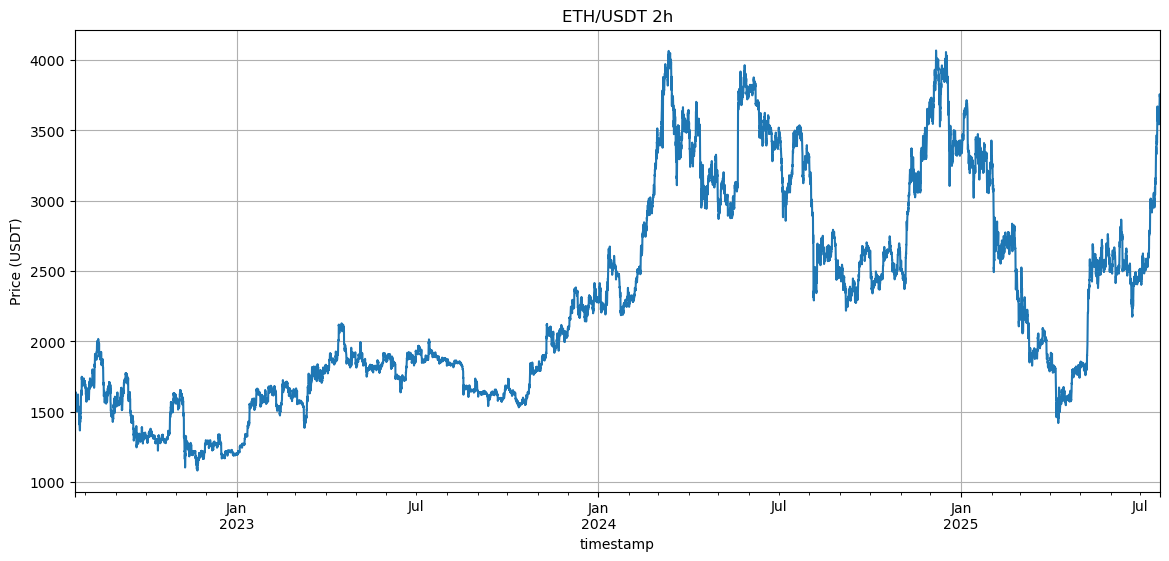

In [7]:
# Plot
df['close'].plot(title='ETH/USDT 2h', figsize=(14, 6))
plt.ylabel('Price (USDT)')
plt.grid()
plt.show()

In [8]:
def zigzag(price_series, threshold=0.05):
    """
    ZigZag indicator for swing high/low detection.
    :param price_series: Series of close prices
    :param threshold: Percent change required to switch trend direction
    :return: List of tuples (index, price) for swing points
    """
    direction = 0  # 0 = undefined, 1 = uptrend, -1 = downtrend
    last_extreme = price_series.iloc[0]
    extreme_index = price_series.index[0]
    swings = [(extreme_index, last_extreme)]

    for idx, price in price_series.iloc[1:].items():
        change = (price - last_extreme) / last_extreme

        if direction == 0:
            if abs(change) >= threshold:
                direction = 1 if change > 0 else -1
                last_extreme = price
                extreme_index = idx
                swings.append((idx, price))

        elif direction == 1:
            if price > last_extreme:
                last_extreme = price
                extreme_index = idx
                swings[-1] = (idx, price)
            elif change < -threshold:
                direction = -1
                last_extreme = price
                extreme_index = idx
                swings.append((idx, price))

        elif direction == -1:
            if price < last_extreme:
                last_extreme = price
                extreme_index = idx
                swings[-1] = (idx, price)
            elif change > threshold:
                direction = 1
                last_extreme = price
                extreme_index = idx
                swings.append((idx, price))

    return swings


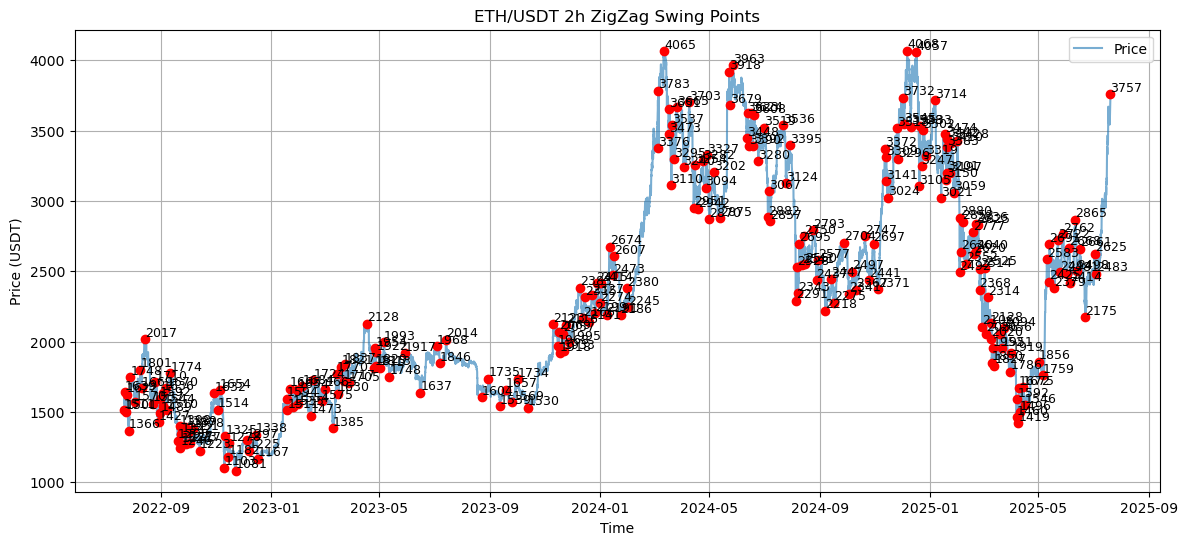

In [9]:
zigzag_points = zigzag(df['close'], threshold=0.05)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', alpha=0.6)

# Plot swing points
for time, price in zigzag_points:
    plt.plot(time, price, 'ro')  # red dot
    plt.text(time, price, f"{price:.0f}", fontsize=9, ha='left', va='bottom')

plt.title('ETH/USDT 2h ZigZag Swing Points')
plt.xlabel('Time')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid()
plt.show()

In [14]:
def detect_5_wave_impulses(swing_points):
    """
    Detect 5-wave impulse patterns from ZigZag points.
    Returns a list of valid impulse wave structures.
    """
    waves = []
    n = len(swing_points)

    for i in range(n - 5):
        pts = swing_points[i:i+6]  # 5 waves have 6 swing points
        idxs, prices = zip(*pts)

        w1 = prices[1] - prices[0]
        w2 = prices[2] - prices[1]
        w3 = prices[3] - prices[2]
        w4 = prices[4] - prices[3]
        w5 = prices[5] - prices[4]

        # Skip if any wave has zero length
        if any(w == 0 for w in [w1, w2, w3, w4, w5]):
            continue

        # Determine trend direction (+1 or -1)
        direction = 1 if w1 > 0 else -1

        # Normalize wave lengths by direction
        w1, w2, w3, w4, w5 = [w * direction for w in [w1, w2, w3, w4, w5]]

        # Elliott rules (simplified)
        if w2 > 0: continue  # Wave 2 should be a pullback
        if w3 <= w1: continue  # Wave 3 must not be shorter than 1
        if w4 > 0: continue  # Wave 4 should be a pullback
        if w5 <= 0: continue  # Final push

        # Optional: Check if wave 4 overlaps wave 1 (violation)
        if direction == 1 and prices[4] < prices[1]: continue
        if direction == -1 and prices[4] > prices[1]: continue

        waves.append({
            'start_idx': idxs[0],
            'end_idx': idxs[5],
            'wave_points': pts,
            'direction': direction,
            'labels': ['0', '1', '2', '3', '4', '5']
        })

    return waves


In [15]:
def plot_wave(df, wave):
    plt.figure(figsize=(14, 6))
    plt.plot(df['close'], label='Price', alpha=0.6)

    for i, (time, price) in enumerate(wave['wave_points']):
        plt.plot(time, price, 'ro')
        plt.text(time, price, wave['labels'][i], fontsize=12, ha='center', va='bottom')

    plt.title('Detected 5-Wave Impulse Pattern')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid()
    plt.show()


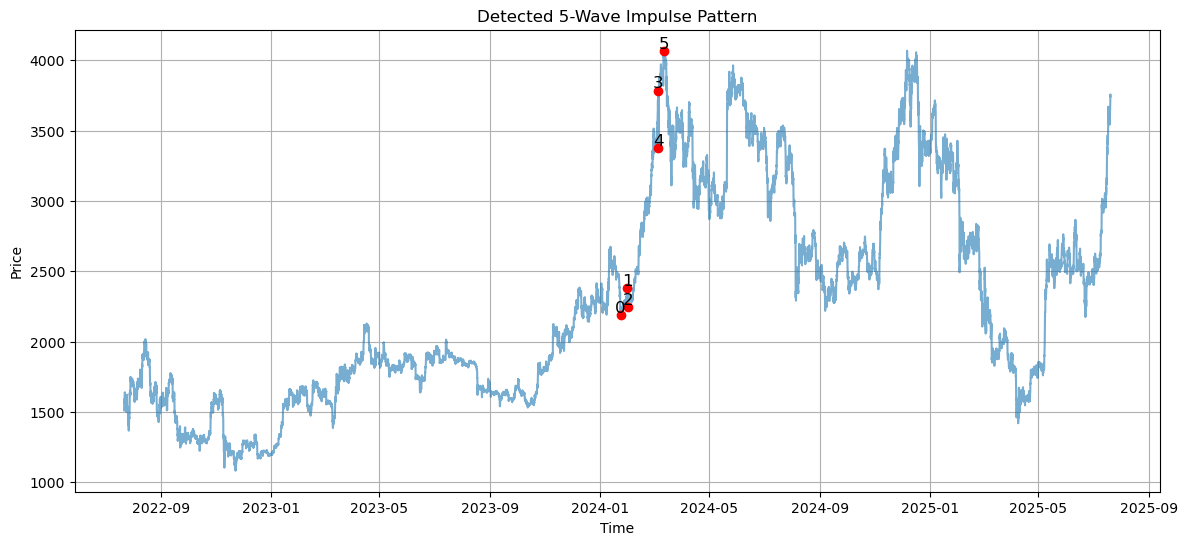

In [26]:
# Assuming you have your ZigZag points from earlier
zigzag_points = zigzag(df['close'], threshold=0.05)
impulses = detect_5_wave_impulses(zigzag_points)

# Plot first detected impulse
if impulses:
    plot_wave(df, impulses[9])
else:
    print("No impulse wave found.")


In [27]:
def detect_abc_corrections(swing_points):
    """
    Detect ABC corrections from ZigZag points.
    Returns a list of valid correction wave structures.
    """
    corrections = []
    n = len(swing_points)

    for i in range(n - 3):
        pts = swing_points[i:i+4]
        idxs, prices = zip(*pts)

        a = prices[1] - prices[0]
        b = prices[2] - prices[1]
        c = prices[3] - prices[2]

        # Skip if any wave is flat
        if any(w == 0 for w in [a, b, c]):
            continue

        # Get direction of wave A
        direction = 1 if a > 0 else -1

        # Normalize waves
        a *= direction
        b *= direction
        c *= direction

        # Rule: B should be corrective (opp direction), C should continue A
        if b >= 0: continue  # B must be opposite
        if c <= 0: continue  # C must continue A

        # Optional: C should go beyond A's endpoint
        if direction == 1 and prices[3] < prices[1]: continue
        if direction == -1 and prices[3] > prices[1]: continue

        corrections.append({
            'start_idx': idxs[0],
            'end_idx': idxs[3],
            'wave_points': pts,
            'direction': direction,
            'labels': ['A', 'B', 'C', 'end']
        })

    return corrections


In [28]:
def plot_correction(df, correction):
    plt.figure(figsize=(14, 6))
    plt.plot(df['close'], label='Price', alpha=0.6)

    for i, (time, price) in enumerate(correction['wave_points']):
        plt.plot(time, price, 'bo')  # blue for correction
        plt.text(time, price, correction['labels'][i], fontsize=12, ha='center', va='bottom')

    plt.title('Detected ABC Correction Pattern')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid()
    plt.show()


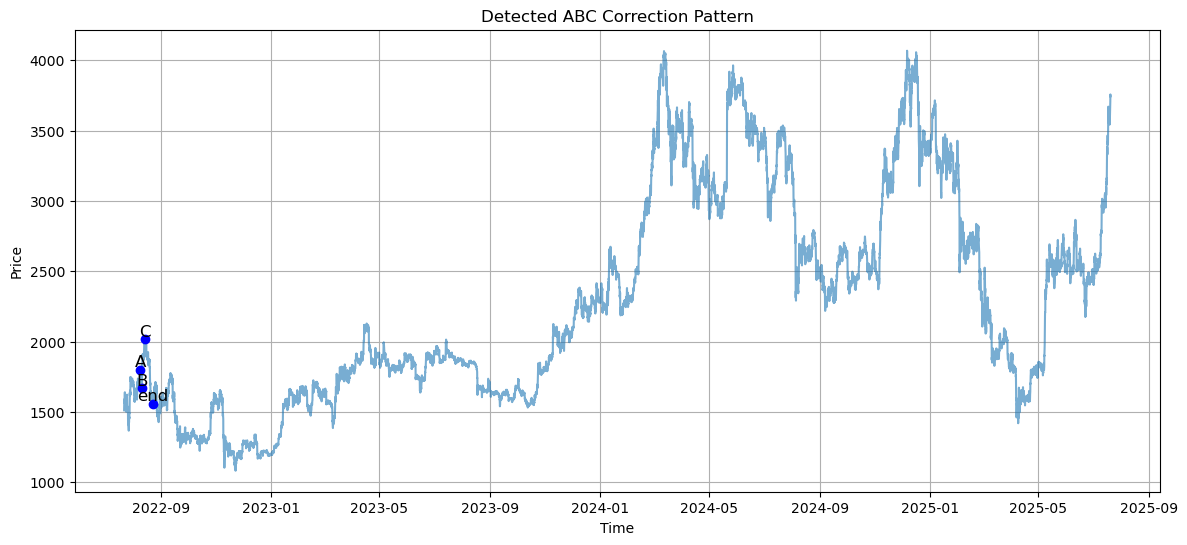

In [33]:
corrections = detect_abc_corrections(zigzag_points)

if corrections:
    plot_correction(df, corrections[4])
else:
    print("No ABC corrections found.")
